In [ ]:
from keras.applications import InceptionResNetV2
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
from keras import models
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.callbacks import  EarlyStopping

In [ ]:
pre_model = InceptionResNetV2(weights = "imagenet", include_top=False, input_shape=(150,150,3))

In [ ]:
pre_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
layer = pre_model.layers[1]

In [ ]:
filters = layer.get_weights()[0]
print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)


In [ ]:
	
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

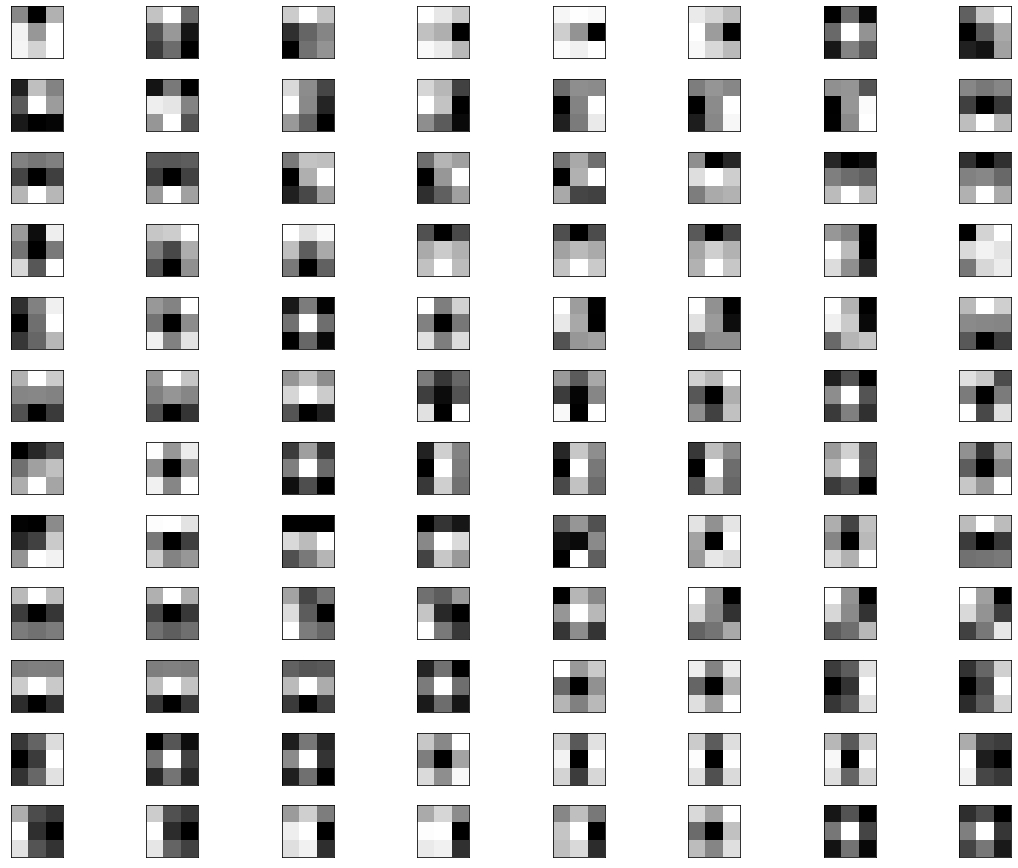

In [ ]:
n_filters, ix= 32, 1
# plot first few filters
plt.figure(figsize=(40,40))
for i in range(filters.shape[3]):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(filters.shape[3], 8, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
    
		ix += 1
# show the figure
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=-0.9, 
                    hspace=0.4)
plt.show()

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
train_ds = datagen.flow_from_directory(
    "drive/MyDrive/CV_data/cats_dogs_dataset/dataset/training_set",
    target_size = (150,150),
    class_mode = "binary",
    batch_size = 8
)
test_ds = datagen.flow_from_directory(
    "drive/MyDrive/CV_data/cats_dogs_dataset/dataset/test_set",
    target_size = (150,150),
    class_mode = "binary",
    batch_size = 8,
    shuffle = False
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# plt.figure(figsize = (10,10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3,3,i+1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
model = models.Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation ='relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
pre_model.trainable = False

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
def plot_confusion_matrix(dataset, model):
  predictions = model.predict(dataset)
  predicted_classes = np.rint(predictions)
  cm = confusion_matrix(dataset.classes, predicted_classes)
  class_labels = list(dataset.class_indices.keys())
  fig = plt.figure(figsize = (8,8))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='Blues',fmt='g');
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)
  ax1.set_xticklabels(class_labels)
  ax1.set_yticklabels(class_labels)
  plt.show()


In [ ]:
model.evaluate(test_ds)

250/250 [==============================] - 204s 793ms/step - loss: 0.7138 - accuracy: 0.6976


[1.1224453449249268, 0.5644999742507935]

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]


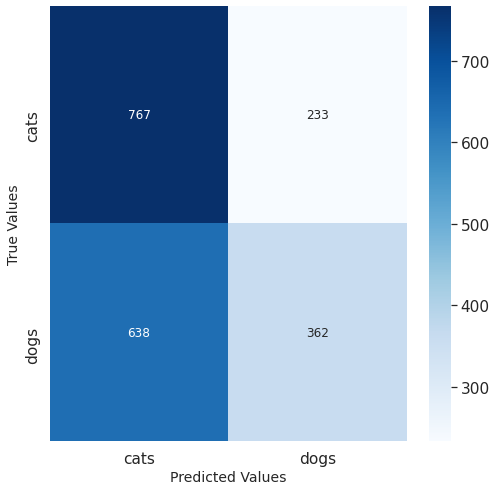

In [ ]:
plot_confusion_matrix(test_ds, model)

In [ ]:
es = EarlyStopping(monitor='loss', mode = "min", patience=3)
model.fit(
    train_ds,
    epochs = 5,
    validation_data = test_ds,
    callbacks = [es]
)

Epoch 1/5
1000/1000 [==============================] - 1023s 1s/step - loss: 0.3874 - accuracy: 0.9578 - val_loss: 0.0780 - val_accuracy: 0.9735
Epoch 2/5
1000/1000 [==============================] - 1016s 1s/step - loss: 0.0729 - accuracy: 0.9745 - val_loss: 0.1570 - val_accuracy: 0.9480
Epoch 3/5
1000/1000 [==============================] - 1017s 1s/step - loss: 0.0688 - accuracy: 0.9761 - val_loss: 0.0699 - val_accuracy: 0.9740
Epoch 4/5
1000/1000 [==============================] - 1007s 1s/step - loss: 0.0546 - accuracy: 0.9801 - val_loss: 0.0952 - val_accuracy: 0.9675
Epoch 5/5
1000/1000 [==============================] - 1023s 1s/step - loss: 0.0417 - accuracy: 0.9855 - val_loss: 0.0869 - val_accuracy: 0.9715


In [ ]:
model.evaluate(test_ds)

250/250 [==============================] - 199s 797ms/step - loss: 0.0869 - accuracy: 0.9715


[0.08694230765104294, 0.9714999794960022]

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


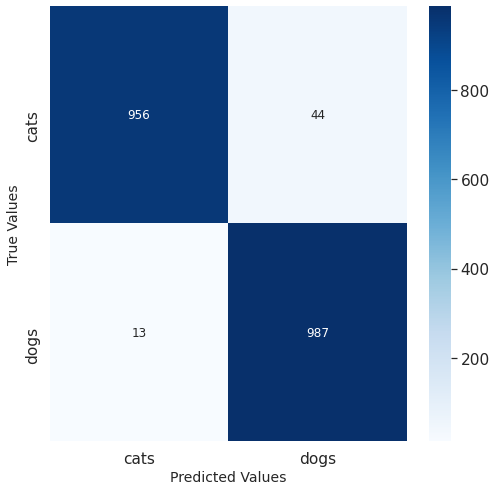

In [ ]:
plot_confusion_matrix(test_ds,model)

In [ ]:
sub_network = models.Sequential()
for i in range(21):
  sub_network.add(pre_model.layers[i])

In [ ]:
new_model = models.Sequential()
new_model.add(sub_network)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(256, activation ='relu'))
new_model.add(layers.Dense(1,activation = 'sigmoid'))

In [ ]:
new_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_22 (Sequential)   (None, 16, 16, 64)        185552    
_________________________________________________________________
flatten_8 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 4,380,369
Trainable params: 4,194,817
Non-trainable params: 185,552
_________________________________________________________________


In [ ]:
sub_network.trainable = False

In [1]:
new_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

NameError: ignored

In [ ]:
new_model.fit(
    train_ds,
    epochs = 5,
    validation_data = test_ds,
    callbacks = [es]
)

Epoch 1/5
1000/1000 [==============================] - 187s 187ms/step - loss: 0.5306 - accuracy: 0.7655 - val_loss: 0.4566 - val_accuracy: 0.7855
Epoch 2/5
1000/1000 [==============================] - 186s 186ms/step - loss: 0.3645 - accuracy: 0.8385 - val_loss: 0.4250 - val_accuracy: 0.8015
Epoch 3/5
1000/1000 [==============================] - 185s 185ms/step - loss: 0.3035 - accuracy: 0.8692 - val_loss: 0.4832 - val_accuracy: 0.7985
Epoch 4/5
1000/1000 [==============================] - 186s 186ms/step - loss: 0.2457 - accuracy: 0.8930 - val_loss: 0.4774 - val_accuracy: 0.8055
Epoch 5/5
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1877 - accuracy: 0.9225 - val_loss: 0.5276 - val_accuracy: 0.8000


In [ ]:
new_model.evaluate(test_ds)

250/250 [==============================] - 35s 139ms/step - loss: 0.5276 - accuracy: 0.8000


[0.5276377201080322, 0.800000011920929]

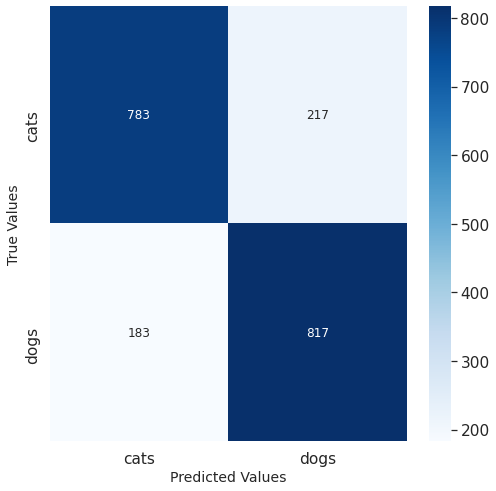

In [ ]:
plot_confusion_matrix(test_ds, new_model)